## 1. Setup and Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import sys
import os

# Ensure `src` directory is on sys.path (helps when running notebook from workspace root)
src_path = os.path.abspath(os.path.join(os.getcwd(), 'src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

print("✓ Libraries imported successfully!")
print(f"Using scikit-learn for KNN implementation")

✓ Libraries imported successfully!
Using scikit-learn for KNN implementation


## 2. Understanding K-Nearest Neighbors

### How KNN Works:

1. **Store** all training data
2. **Calculate** distance from new point to all training points
3. **Find** K nearest neighbors
4. **Vote**: Use majority class of K neighbors

### Key Concepts:

$$\text{Euclidean Distance} = \sqrt{\sum_{i=1}^{n}(x_i - y_i)^2}$$

**Pros:**
- Simple and intuitive
- No training phase (lazy learning)
- Works well with small datasets
- Non-parametric

**Cons:**
- Slow prediction (must compare to all points)
- Sensitive to irrelevant features
- Requires feature scaling
- Memory intensive

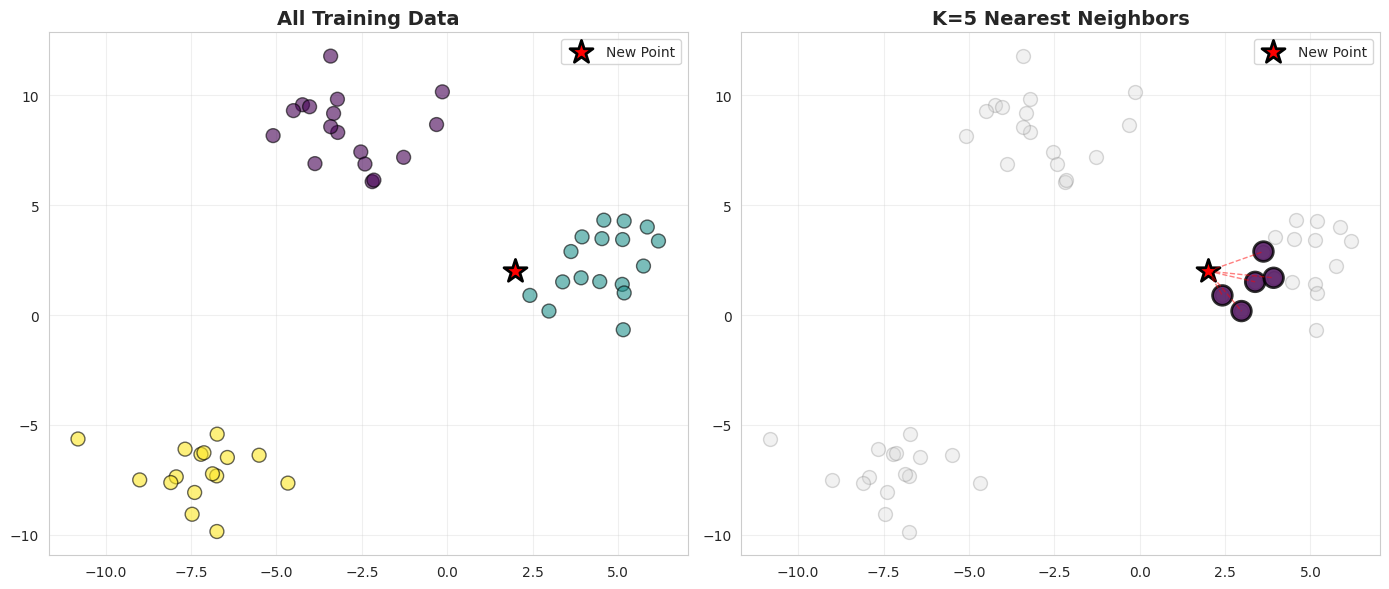


K = 5
Neighbor classes: [1 1 1 1 1]
Predicted class: 1 (majority vote)


In [2]:
# Visualize KNN concept
def visualize_knn_concept():
    """Visualize how KNN makes decisions"""
    np.random.seed(42)
    
    # Create 2D dataset
    from sklearn.datasets import make_blobs
    X, y = make_blobs(n_samples=50, centers=3, n_features=2, 
                      random_state=42, cluster_std=1.5)
    
    # New point to classify
    new_point = np.array([[2, 2]])
    
    # Calculate distances
    distances = np.sqrt(np.sum((X - new_point)**2, axis=1))
    k = 5
    nearest_indices = np.argsort(distances)[:k]
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: All data
    scatter = axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', 
                              s=100, alpha=0.6, edgecolors='black')
    axes[0].scatter(new_point[0, 0], new_point[0, 1], 
                   color='red', s=300, marker='*', 
                   edgecolors='black', linewidths=2, label='New Point')
    axes[0].set_title('All Training Data', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: K nearest neighbors
    axes[1].scatter(X[:, 0], X[:, 1], c='lightgray', 
                   s=100, alpha=0.3, edgecolors='gray')
    axes[1].scatter(X[nearest_indices, 0], X[nearest_indices, 1], 
                   c=y[nearest_indices], cmap='viridis',
                   s=200, alpha=0.8, edgecolors='black', linewidths=2)
    axes[1].scatter(new_point[0, 0], new_point[0, 1], 
                   color='red', s=300, marker='*', 
                   edgecolors='black', linewidths=2, label='New Point')
    
    # Draw lines to neighbors
    for idx in nearest_indices:
        axes[1].plot([new_point[0, 0], X[idx, 0]], 
                    [new_point[0, 1], X[idx, 1]], 
                    'r--', alpha=0.5, linewidth=1)
    
    axes[1].set_title(f'K={k} Nearest Neighbors', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Determine class
    neighbor_classes = y[nearest_indices]
    predicted_class = np.bincount(neighbor_classes).argmax()
    print(f"\nK = {k}")
    print(f"Neighbor classes: {neighbor_classes}")
    print(f"Predicted class: {predicted_class} (majority vote)")

visualize_knn_concept()

## 3. Distance Metrics Comparison

In [3]:
# Different distance metrics
def compare_distance_metrics(point1, point2):
    """Compare different distance metrics"""
    p1 = np.array(point1)
    p2 = np.array(point2)
    
    # Euclidean distance (L2)
    euclidean = np.sqrt(np.sum((p1 - p2)**2))
    
    # Manhattan distance (L1)
    manhattan = np.sum(np.abs(p1 - p2))
    
    # Chebyshev distance (L-infinity)
    chebyshev = np.max(np.abs(p1 - p2))
    
    # Minkowski distance (p=3)
    minkowski = np.sum(np.abs(p1 - p2)**3)**(1/3)
    
    print(f"Point 1: {p1}")
    print(f"Point 2: {p2}")
    print(f"\nDistance Metrics:")
    print(f"  Euclidean:  {euclidean:.4f}")
    print(f"  Manhattan:  {manhattan:.4f}")
    print(f"  Chebyshev:  {chebyshev:.4f}")
    print(f"  Minkowski:  {minkowski:.4f}")
    
    return euclidean, manhattan, chebyshev, minkowski

# Test with example points
compare_distance_metrics([0, 0], [3, 4])
compare_distance_metrics([1, 2, 3], [4, 5, 6])

Point 1: [0 0]
Point 2: [3 4]

Distance Metrics:
  Euclidean:  5.0000
  Manhattan:  7.0000
  Chebyshev:  4.0000
  Minkowski:  4.4979
Point 1: [1 2 3]
Point 2: [4 5 6]

Distance Metrics:
  Euclidean:  5.1962
  Manhattan:  9.0000
  Chebyshev:  3.0000
  Minkowski:  4.3267


(np.float64(5.196152422706632),
 np.int64(9),
 np.int64(3),
 np.float64(4.3267487109222245))

## 4. Build KNN Face Recognizer

Let's use the same data structure as our SVM project

In [4]:
# Import our feature extraction modules (use package imports so static checkers resolve them)
try:
    # Prefer package-style imports (src.*) so editors like Pylance can resolve the modules
    from src.face_detector import FaceDetector
    from src.feature_extractor import FeatureExtractor
    from src.utils import load_model, create_directory
    print("✓ Modules imported successfully")
except Exception as e:
    # Fall back to synthetic data if the package isn't available at runtime
    print(f"Note: Could not import custom modules: {e}")
    print("Using synthetic data for demonstration")

# Create synthetic dataset for demonstration
X, y = make_classification(
    n_samples=300,
    n_features=50,
    n_informative=40,
    n_redundant=5,
    n_classes=3,
    n_clusters_per_class=1,
    random_state=42
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features (IMPORTANT for KNN!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset prepared:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Features: {X_train.shape[1]}")
print(f"  Classes: {len(np.unique(y))}")

✓ Modules imported successfully
Dataset prepared:
  Training samples: 210
  Test samples: 90
  Features: 50
  Classes: 3


In [5]:
# Train KNN classifier
print("Training KNN classifier...\n")

# Try different K values
k_values = [1, 3, 5, 7, 9, 11, 15]
results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    
    results.append({
        'k': k,
        'train_score': train_score,
        'test_score': test_score
    })
    
    print(f"K={k:2d} | Train: {train_score:.4f} | Test: {test_score:.4f}")

print("\n✓ Training completed!")

Training KNN classifier...

K= 1 | Train: 1.0000 | Test: 0.8556
K= 3 | Train: 0.9476 | Test: 0.8556
K= 5 | Train: 0.9238 | Test: 0.9000
K= 7 | Train: 0.9238 | Test: 0.9000
K= 9 | Train: 0.9429 | Test: 0.8778
K=11 | Train: 0.9381 | Test: 0.9000
K=15 | Train: 0.9429 | Test: 0.8889

✓ Training completed!


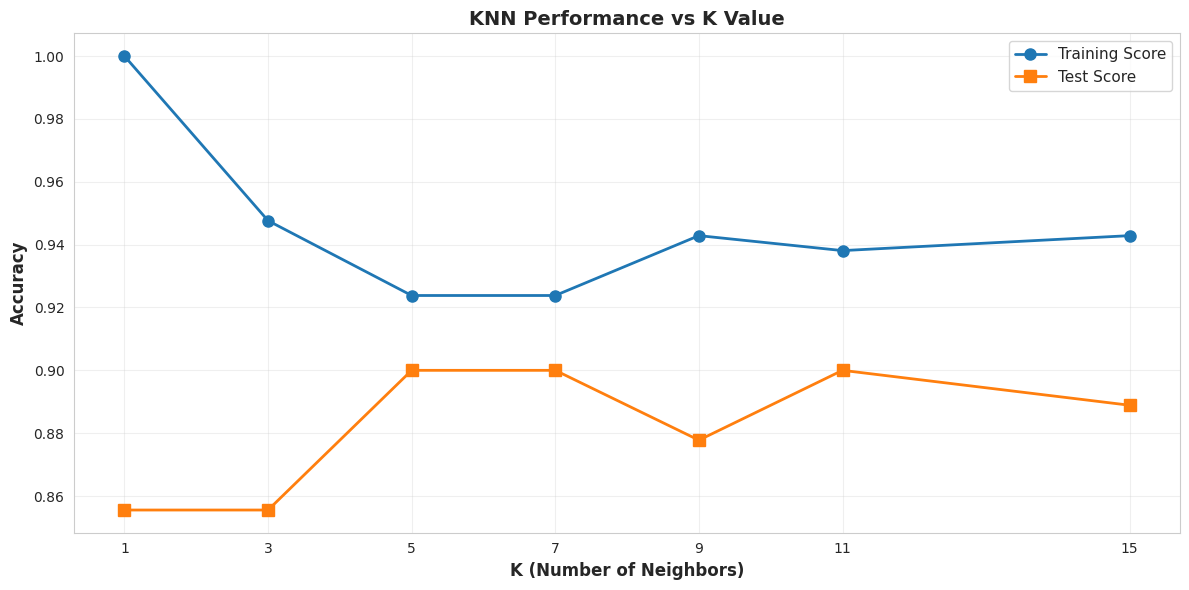


Optimal K: 5 (Test Accuracy: 0.9000)


In [6]:
# Visualize effect of K
import pandas as pd

df_results = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
plt.plot(df_results['k'], df_results['train_score'], 
         'o-', linewidth=2, markersize=8, label='Training Score')
plt.plot(df_results['k'], df_results['test_score'], 
         's-', linewidth=2, markersize=8, label='Test Score')

plt.xlabel('K (Number of Neighbors)', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('KNN Performance vs K Value', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

plt.tight_layout()
plt.show()

# Find optimal K
best_idx = df_results['test_score'].idxmax()
best_k = df_results.loc[best_idx, 'k']
best_score = df_results.loc[best_idx, 'test_score']

print(f"\nOptimal K: {int(best_k)} (Test Accuracy: {best_score:.4f})")

## 5. Train Final KNN Model

In [7]:
# Train final model with optimal K
optimal_k = int(best_k)

knn_final = KNeighborsClassifier(
    n_neighbors=optimal_k,
    weights='distance',  # Weight by inverse distance
    metric='euclidean',
    n_jobs=-1  # Use all CPU cores
)

knn_final.fit(X_train_scaled, y_train)

# Predictions
y_pred = knn_final.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)

print(f"Final KNN Model (K={optimal_k})")
print("="*60)
print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                           target_names=['Person A', 'Person B', 'Person C']))

Final KNN Model (K=5)

Test Accuracy: 0.9111

Classification Report:
              precision    recall  f1-score   support

    Person A       0.86      1.00      0.92        30
    Person B       0.96      0.80      0.87        30
    Person C       0.93      0.93      0.93        30

    accuracy                           0.91        90
   macro avg       0.92      0.91      0.91        90
weighted avg       0.92      0.91      0.91        90



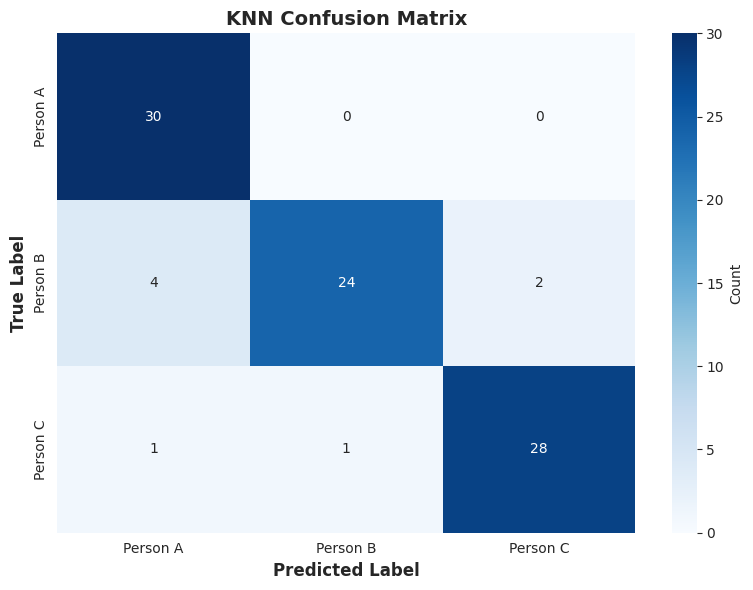

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Person A', 'Person B', 'Person C'],
            yticklabels=['Person A', 'Person B', 'Person C'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('KNN Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Cross-Validation

5-Fold Cross-Validation Results:
Fold 1: 0.8571
Fold 2: 0.9524
Fold 3: 0.8810
Fold 4: 0.9286
Fold 5: 0.9048

Mean CV Score: 0.9048 (+/- 0.0337)


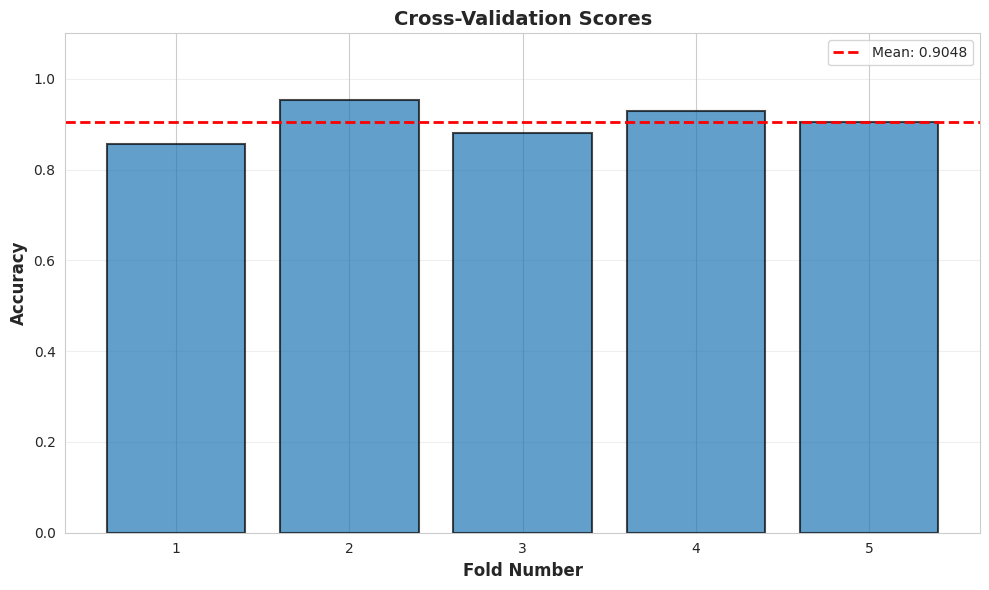

In [9]:
# Perform cross-validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(knn_final, X_train_scaled, y_train, cv=5)

print("5-Fold Cross-Validation Results:")
print("="*60)
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")

print(f"\nMean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.axhline(cv_scores.mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold Number', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.ylim([0, 1.1])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 7. KNN vs SVM Comparison

In [10]:
# Compare KNN with SVM
from sklearn.svm import SVC
import time

print("Comparing KNN vs SVM")
print("="*60)

# Train SVM
print("\nTraining SVM...")
start_time = time.time()
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train_scaled, y_train)
svm_train_time = time.time() - start_time

# Train KNN
print("Training KNN...")
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train_scaled, y_train)
knn_train_time = time.time() - start_time

# Test predictions
print("\nTesting...")
start_time = time.time()
svm_pred = svm.predict(X_test_scaled)
svm_pred_time = time.time() - start_time

start_time = time.time()
knn_pred = knn.predict(X_test_scaled)
knn_pred_time = time.time() - start_time

# Compare results
comparison = {
    'Metric': ['Training Time', 'Prediction Time', 'Test Accuracy', 'Memory Usage'],
    'SVM': [
        f'{svm_train_time:.4f}s',
        f'{svm_pred_time:.4f}s',
        f'{accuracy_score(y_test, svm_pred):.4f}',
        'Low (stores support vectors)'
    ],
    'KNN': [
        f'{knn_train_time:.4f}s',
        f'{knn_pred_time:.4f}s',
        f'{accuracy_score(y_test, knn_pred):.4f}',
        'High (stores all training data)'
    ]
}

df_comparison = pd.DataFrame(comparison)
print("\n" + df_comparison.to_string(index=False))

print("\n" + "="*60)
print("KEY DIFFERENCES:")
print("="*60)
print("SVM:")
print("  ✓ Faster prediction (uses support vectors)")
print("  ✓ Better with high-dimensional data")
print("  ✓ More memory efficient")
print("  ✗ Slower training")
print("  ✗ Requires parameter tuning")
print("\nKNN:")
print("  ✓ Instant training (no model building)")
print("  ✓ Simple and intuitive")
print("  ✓ Good with small datasets")
print("  ✗ Slow prediction (compares to all points)")
print("  ✗ Requires lots of memory")
print("  ✗ Sensitive to irrelevant features")

Comparing KNN vs SVM

Training SVM...
Training KNN...

Testing...

         Metric                          SVM                             KNN
  Training Time                      0.0043s                         0.0003s
Prediction Time                      0.0007s                         0.0007s
  Test Accuracy                       0.9000                          0.9000
   Memory Usage Low (stores support vectors) High (stores all training data)

KEY DIFFERENCES:
SVM:
  ✓ Faster prediction (uses support vectors)
  ✓ Better with high-dimensional data
  ✓ More memory efficient
  ✗ Slower training
  ✗ Requires parameter tuning

KNN:
  ✓ Instant training (no model building)
  ✓ Simple and intuitive
  ✓ Good with small datasets
  ✗ Slow prediction (compares to all points)
  ✗ Requires lots of memory
  ✗ Sensitive to irrelevant features


## 8. Optimizing KNN Parameters

Performing Grid Search for KNN...
Testing 48 combinations

Best Parameters:
  metric: euclidean
  n_neighbors: 11
  weights: uniform

Best CV Score: 0.9381
Test Score: 0.9000


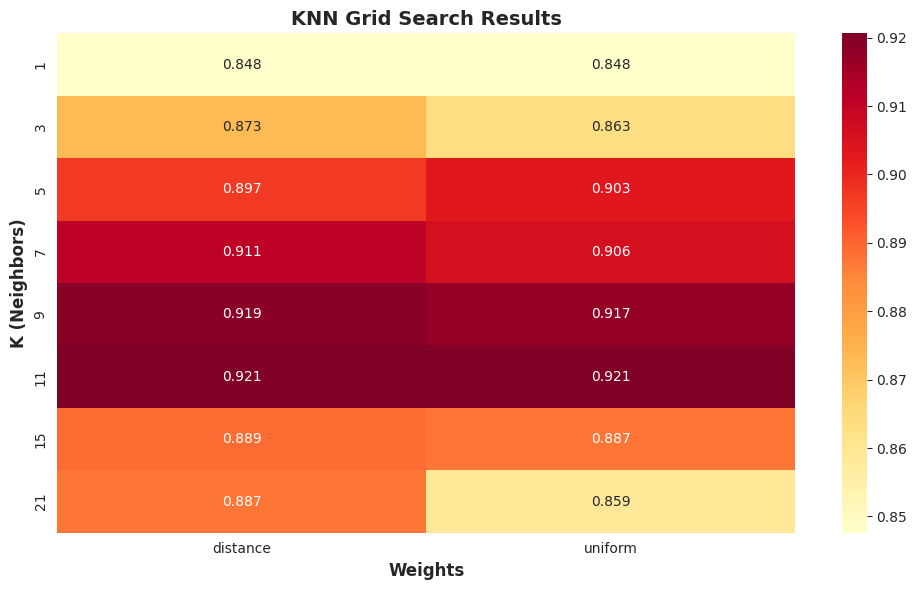

In [11]:
# Grid search for KNN
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

print("Performing Grid Search for KNN...")
print(f"Testing {np.prod([len(v) for v in param_grid.values()])} combinations\n")

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score: {grid_search.best_score_:.4f}")
print(f"Test Score: {grid_search.score(X_test_scaled, y_test):.4f}")

# Visualize results
results_df = pd.DataFrame(grid_search.cv_results_)
pivot = results_df.pivot_table(
    values='mean_test_score',
    index='param_n_neighbors',
    columns='param_weights',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd')
plt.xlabel('Weights', fontsize=12, fontweight='bold')
plt.ylabel('K (Neighbors)', fontsize=12, fontweight='bold')
plt.title('KNN Grid Search Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Practical Application: Complete Pipeline

In [12]:
class KNNFaceRecognizer:
    """Complete KNN Face Recognition Pipeline"""
    
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights='distance',
            n_jobs=-1
        )
        self.scaler = StandardScaler()
        self.label_names = {}
        
    def train(self, X_train, y_train, label_names=None):
        """Train the KNN model"""
        # Scale features
        X_scaled = self.scaler.fit_transform(X_train)
        
        # Train model
        self.knn.fit(X_scaled, y_train)
        
        # Store label names
        if label_names:
            self.label_names = label_names
        else:
            self.label_names = {i: f"Person {i}" for i in np.unique(y_train)}
        
        print(f"✓ Model trained with {len(X_train)} samples")
        print(f"✓ Recognizing {len(self.label_names)} people")
        
    def predict(self, X_test, return_confidence=False):
        """Predict labels for test data"""
        X_scaled = self.scaler.transform(X_test)
        predictions = self.knn.predict(X_scaled)
        
        if return_confidence:
            # Get distances to K nearest neighbors
            distances, indices = self.knn.kneighbors(X_scaled)
            # Confidence = inverse of mean distance
            confidence = 1 / (1 + distances.mean(axis=1))
            return predictions, confidence
        
        return predictions
    
    def predict_single(self, features):
        """Predict single face"""
        features = features.reshape(1, -1)
        predictions, confidence = self.predict(features, return_confidence=True)
        
        label = predictions[0]
        name = self.label_names[label]
        conf = confidence[0]
        
        return name, conf
    
    def evaluate(self, X_test, y_test):
        """Evaluate model"""
        predictions = self.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        
        print(f"\nModel Evaluation:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"\nClassification Report:")
        print(classification_report(y_test, predictions,
                                   target_names=list(self.label_names.values())))
        
        return accuracy

# Test the complete pipeline
recognizer = KNNFaceRecognizer(n_neighbors=int(best_k))
label_names = {0: "Alice", 1: "Bob", 2: "Charlie"}
recognizer.train(X_train, y_train, label_names)
recognizer.evaluate(X_test, y_test)

# Test single prediction
test_sample = X_test[0]
name, confidence = recognizer.predict_single(test_sample)
print(f"\nSingle Prediction:")
print(f"  Predicted: {name}")
print(f"  Confidence: {confidence:.4f}")
print(f"  Actual: {label_names[y_test[0]]}")

✓ Model trained with 210 samples
✓ Recognizing 3 people

Model Evaluation:
  Accuracy: 0.9111

Classification Report:
              precision    recall  f1-score   support

       Alice       0.86      1.00      0.92        30
         Bob       0.96      0.80      0.87        30
     Charlie       0.93      0.93      0.93        30

    accuracy                           0.91        90
   macro avg       0.92      0.91      0.91        90
weighted avg       0.92      0.91      0.91        90


Single Prediction:
  Predicted: Alice
  Confidence: 0.1180
  Actual: Alice


## 10. Key Takeaways

### What You've Learned:

✅ **KNN Algorithm**: Distance-based classification  
✅ **Distance Metrics**: Euclidean, Manhattan, etc.  
✅ **K Selection**: Impact on bias-variance tradeoff  
✅ **Feature Scaling**: Critical for KNN performance  
✅ **KNN vs SVM**: Trade-offs and use cases  
✅ **Optimization**: Grid search for best parameters  

### When to Use KNN:

✓ Small to medium datasets  
✓ Low-dimensional features  
✓ Need simple, interpretable model  
✓ Instant training required  
✓ Non-linear decision boundaries  

### When to Use SVM:

✓ Large datasets  
✓ High-dimensional features  
✓ Need fast predictions  
✓ Complex decision boundaries  
✓ Memory constraints  

### KNN Best Practices:

1. **Always scale features** - KNN is distance-based
2. **Choose K wisely** - Too small = noise, too large = blur
3. **Use cross-validation** - Find optimal K
4. **Weight by distance** - Closer neighbors more important
5. **Consider dimensionality** - Reduce features if possible

### Quick Comparison:

| Aspect | KNN | SVM |
|--------|-----|-----|
| Training | Instant | Slow |
| Prediction | Slow | Fast |
| Memory | High | Low |
| Parameters | K, metric | C, gamma, kernel |
| Scalability | Poor | Good |

### Common Pitfalls:

❌ Not scaling features  
❌ Using too small K (overfitting)  
❌ Using too large K (underfitting)  
❌ Ignoring curse of dimensionality  
❌ Not removing irrelevant features  

### Next Steps:

- Try KNN on real face dataset
- Experiment with different distance metrics
- Compare with Random Forest (next notebook)
- Implement feature selection

## 11. Additional Resources

### Papers:
- ["Nearest Neighbor Pattern Classification" (Cover & Hart, 1967)](https://ieeexplore.ieee.org/document/1053964)

### Tutorials:
- [scikit-learn KNN](https://scikit-learn.org/stable/modules/neighbors.html)
- [StatQuest: K-Nearest Neighbors](https://www.youtube.com/watch?v=HVXime0nQeI)

---

**Created for Computer Vision Course**  
**Algorithm: K-Nearest Neighbors (KNN)**  
**Date: 2025**